In [1]:
%matplotlib inline
from IPython.display import HTML
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../src/processing/')
import tools

## A Common City Scene
If you've ever ridden the bus, you've probably had the following experience. You're standing at the bus stop waiting for the bus to come. You've been waiting over ten minutes. You're running late to an important meeting, a date, or maybe a house warming party you didn't really want to go to. Some people at the bus stop are commenting out loud about how this bus is *always* late. Others are checking their transit apps or Google maps and complaining how the apps always lie: "it said the bus was coming in five minutes, five minutes ago!" One guy keeps stepping into the street every 30 seconds and staring down oncoming traffic to check for the bus. Suddenly, you see the bus appear in the distance. As the bus gets closer you realize, there's not just one bus, but two buses! (If it's a strange day, maybe there is a caravan of three buses arriving together or in close succession). If you're lucky, you witnessed this from the bus stop across the street. This phenomenon is appropriately called bus bunching.

## What is Bus Bunching?
Bus bunching is when two or more buses on the same route arrive at a bus stop together or in close succession. Bus bunching occurs when the headway, or the temporal distance, between two buses is sufficiently small. What counts as "sufficiently small" depends on the context. There's no standard threshold headway used to define bus bunching. On a high frequency route, two buses may be considered bunched if the headway between them is 2 minutes or less. On a lower frequency route, however, two buses may be considered bunched at headways over 5 minutes.

## What Causes Bus Bunching?
Bus bunching has a number of possible causes: 
* The sheer volume of passengers entering the bus at a given stop or stops. From this arises a possible negative feedback loop: as passengers entering and exiting further along the route the have a harder time navigating the crowd, service continues to slow down.
* The amount of traffic on the road
* The number of available lanes decreases at some point along the route, whether from construction or the road's design
* A bus operator driving too fast or too slow

Determining when and where bus bunching occurs along a route is critical for transit planners working to improve service. 

## The Data
--Describe datasets used. Route 73 wait time data + route pattern.

## The Goal
My primary goal is to learn where bus bunching tends to occur along Route 73 Armitage. I'm also interested in learning if bus bunching occurs more often at certain times of the day. My plan is to create a series of heatmap-like visualizations indexed by time that highlight the bus stops at which the most bunching incidents were observed during the data collection period. The idea is for the heatmap to be visually similar to Google Traffic that communicates traffic conditions as a colored overlay on city streets.

### Load the data
Load the pattern data for Route 73 Armitage. Each row represents either a bus stop (``typ == 'S'``) or an intermediate waypoint (``typ == 'W'``). I load the patterns with the waypoints, since they will allow me to create a more accurate image of the route. For simplicity, I will only work with one pattern: pid 2170 (eastbound trips between Laramie and Clark & North).

In [2]:
patterns = tools.load_patterns(73, waypoints=True)
patterns = patterns[patterns.pid == 2170]
patterns.head()

,lat,lon,pdist,seq,stpid,stpnm,typ,ln,pid,rtdir
316,41.917362,-87.757532,0.0,1,14179,Grand & Latrobe Terminal,S,38236.0,2170,Eastbound
317,41.917203,-87.757500,0.0,2,NaN,NaN,W,38236.0,2170,Eastbound
318,41.916853,-87.756357,0.0,3,NaN,NaN,W,38236.0,2170,Eastbound
319,41.916917,-87.756070,470.0,4,689,Grand & Laramie,S,38236.0,2170,Eastbound
320,41.916853,-87.755672,0.0,5,NaN,NaN,W,38236.0,2170,Eastbound


We can get an idea of the shape of the route pattern by creating a [LineString](http://toblerity.org/shapely/manual.html#linestrings) object from the latitude and longitude of each of its stops and waypoints using the [Shapely](https://github.com/Toblerity/Shapely) library.

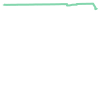

In [3]:
from shapely.geometry import LineString

LineString(zip(patterns.lon, patterns.lat))

To create something like a heatmap, I need to "bin" the pattern into smaller segments and color each according to the number of bunching incidents observed on that segment. Bunching can be determined using the travels_waits dataset, which records the wait times between buses at each stop along the route. A logical way then to divide the pattern is by creating segments with end points at adjacent bus stops labeled with the name of the stop visited earlier in the sequence. Any waypoints falling between the two end points should be included in the segment, so as to preserve the route's shape. It is possible that some segments won't be straight line, and that is okay. Finally, all of the coordinates corresponding to the stops and waypoints making up each segment must be used to generate a LineString, so that they can be mapped.

To accomplish the above for each pair of adjacent stops A and B, I will:
* Associate all waypoints between stop A and B with stop A.
* Append all lon-lat coordinates associated with stop A to a list in sequence order.
* Append the coordinates of stop B to the end of the previous list.
* Create a LineString from the coordinate list.

Once the above steps are accomplished, I can load the geometry data into a `GeoDataFrame` so that it can be plotted.

### Transform the data
Conveniently, waypoints have null-valued stpnm and stpid. I make sure the `DataFrame` is in sequence order, and then apply the forward fill method ``.ffill()`` to populate the null values in those fields with the name and id of the previous stop. I drop any remaining rows with null values, i.e. any points along the route before the first stop.

In [4]:
patterns.sort_values('seq')
patterns.ffill(inplace=True)
patterns.dropna(inplace=True)
patterns.head()

,lat,lon,pdist,seq,stpid,stpnm,typ,ln,pid,rtdir
316,41.917362,-87.757532,0.0,1,14179,Grand & Latrobe Terminal,S,38236.0,2170,Eastbound
317,41.917203,-87.757500,0.0,2,14179,Grand & Latrobe Terminal,W,38236.0,2170,Eastbound
318,41.916853,-87.756357,0.0,3,14179,Grand & Latrobe Terminal,W,38236.0,2170,Eastbound
319,41.916917,-87.756070,470.0,4,689,Grand & Laramie,S,38236.0,2170,Eastbound
320,41.916853,-87.755672,0.0,5,689,Grand & Laramie,W,38236.0,2170,Eastbound


Next, I populate the column lon_lat with one-item lists containing a tuple of each row's latitude and longitude. Grouping the `DataFrame` by stpid and applying ``sum`` to the lon_lat column concatenates the one-item coordinate lists together.

In [5]:
patterns['lon_lat'] = [[xy] for xy in zip(patterns.lon, patterns.lat)]
grouped = patterns.groupby(['stpid']).lon_lat.agg('sum').to_frame().reset_index()
grouped.head()

,stpid,lon_lat
0,1405,"[(-87.636193, 41.918372), (-87.635987, 41.9183..."
1,1409,"[(-87.633952, 41.914962), (-87.633317, 41.914)..."
2,1410,"[(-87.633125, 41.912522), (-87.632982, 41.9112..."
3,14179,"[(-87.757532, 41.917362), (-87.7575, 41.917203..."
4,15220,"[(-87.677233, 41.91779), (-87.676152, 41.91783..."


I join this result back to the patterns `DataFrame`.

In [6]:
merged = patterns.merge(grouped, on='stpid')
merged.head()

,lat,lon,pdist,seq,stpid,stpnm,typ,ln,pid,rtdir,lon_lat_x,lon_lat_y
0,41.917362,-87.757532,0.0,1,14179,Grand & Latrobe Terminal,S,38236.0,2170,Eastbound,"[(-87.757532, 41.917362)]","[(-87.757532, 41.917362), (-87.7575, 41.917203..."
1,41.917203,-87.757500,0.0,2,14179,Grand & Latrobe Terminal,W,38236.0,2170,Eastbound,"[(-87.7575, 41.917203)]","[(-87.757532, 41.917362), (-87.7575, 41.917203..."
2,41.916853,-87.756357,0.0,3,14179,Grand & Latrobe Terminal,W,38236.0,2170,Eastbound,"[(-87.756357, 41.916853)]","[(-87.757532, 41.917362), (-87.7575, 41.917203..."
3,41.916917,-87.756070,470.0,4,689,Grand & Laramie,S,38236.0,2170,Eastbound,"[(-87.75607, 41.916917)]","[(-87.75607, 41.916917), (-87.755672, 41.91685..."
4,41.916853,-87.755672,0.0,5,689,Grand & Laramie,W,38236.0,2170,Eastbound,"[(-87.755672, 41.916853)]","[(-87.75607, 41.916917), (-87.755672, 41.91685..."


I drop the waypoints from the `DataFrame`, since they are no longer needed. I also rename some of the columns. 

In [7]:
merged = merged[merged.typ != "W"]
merged.rename({'lon_lat_y': 'coordinates', 'lon_lat_x': 'lon_lat'}, inplace=True, axis='columns')
merged.head()

,lat,lon,pdist,seq,stpid,stpnm,typ,ln,pid,rtdir,lon_lat,coordinates
0,41.917362,-87.757532,0.0,1,14179,Grand & Latrobe Terminal,S,38236.0,2170,Eastbound,"[(-87.757532, 41.917362)]","[(-87.757532, 41.917362), (-87.7575, 41.917203..."
3,41.916917,-87.756070,470.0,4,689,Grand & Laramie,S,38236.0,2170,Eastbound,"[(-87.75607, 41.916917)]","[(-87.75607, 41.916917), (-87.755672, 41.91685..."
7,41.916828,-87.752573,1429.0,8,4027,Armitage & Leclaire/Grand,S,38236.0,2170,Eastbound,"[(-87.752573, 41.916828)]","[(-87.752573, 41.916828), (-87.751253, 41.9168..."
9,41.916822,-87.751143,1838.0,10,4028,Armitage & Lavergne,S,38236.0,2170,Eastbound,"[(-87.751143, 41.916822)]","[(-87.751143, 41.916822), (-87.750523, 41.9168..."
12,41.916828,-87.749648,2249.0,13,4029,Armitage & Lamon,S,38236.0,2170,Eastbound,"[(-87.749648, 41.916828)]","[(-87.749648, 41.916828), (-87.747757, 41.9168..."


The coordinate lists include all of the points up to but not including the final end point. To include the final endpoint, I concatenate the coordinates of each bus stop (``lon_lat``) to the coordinate list (``coordinates``) in the row above it with the help of the  ``.shift()`` method and the `+` operator. Passing -1 to ``.shift()`` shifts each row backward by 1, so that the 0th row is removed, the 1st row becomes the 0th row, and so on, and the last row becomes null. When the `+` operator is applied to two Series of lists, it concatenates the lists in each Series. Notice that a non-null value `+ NaN = NaN`.

In [8]:
merged.coordinates = (merged.coordinates + merged.lon_lat.shift(-1))
merged.tail()

,lat,lon,pdist,seq,stpid,stpnm,typ,ln,pid,rtdir,lon_lat,coordinates
156,41.916725,-87.635065,35097.0,157,1843,Clark & Wisconsin,S,38236.0,2170,Eastbound,"[(-87.635065, 41.916725)]","[(-87.635065, 41.916725), (-87.635097, 41.9166..."
160,41.914962,-87.633952,35822.0,161,1409,Clark & Menomonee,S,38236.0,2170,Eastbound,"[(-87.633952, 41.914962)]","[(-87.633952, 41.914962), (-87.633317, 41.914)..."
165,41.912522,-87.633125,36756.0,166,1410,Lasalle & Eugenie,S,38236.0,2170,Eastbound,"[(-87.633125, 41.912522)]","[(-87.633125, 41.912522), (-87.632982, 41.9112..."
169,41.911067,-87.632568,37395.0,170,15276,North Avenue + Lasalle,S,38236.0,2170,Eastbound,"[(-87.632568, 41.911067)]","[(-87.632568, 41.911067), (-87.632553, 41.9112..."
173,41.911512,-87.631647,37759.0,174,15417,Clark & North,S,38236.0,2170,Eastbound,"[(-87.631647, 41.911512)]",NaN


### Load the data into a `GeoDataFrame`
Once I create a LineString for each list of coordinates, I can load the `DataFrame` and the geometry into a `GeoDataFrame`.

In [21]:
import geopandas as gpd

merged.dropna(inplace=True)
geometry = [LineString(xys) for xys in merged.coordinates]
gdf = gpd.GeoDataFrame(merged, geometry=geometry)
gdf.drop(['lon', 'lat', 'lon_lat', 'coordinates'], inplace=True, axis=1)
gdf.head()

,pdist,seq,stpid,stpnm,typ,ln,pid,rtdir,geometry
0,0.0,1,14179,Grand & Latrobe Terminal,S,38236.0,2170,Eastbound,LINESTRING (-87.75753200000101 41.917362000001...
3,470.0,4,689,Grand & Laramie,S,38236.0,2170,Eastbound,"LINESTRING (-87.756069999999 41.916917, -87.75..."
7,1429.0,8,4027,Armitage & Leclaire/Grand,S,38236.0,2170,Eastbound,"LINESTRING (-87.752572999999 41.916827999999, ..."
9,1838.0,10,4028,Armitage & Lavergne,S,38236.0,2170,Eastbound,"LINESTRING (-87.751143000002 41.916821999999, ..."
12,2249.0,13,4029,Armitage & Lamon,S,38236.0,2170,Eastbound,LINESTRING (-87.74964799999999 41.916827999999...


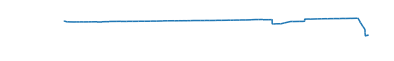

In [25]:
gdf.plot().set_axis_off()

### Create the heatmap
To color the map, I need to associate each segment with the corresponding number of observed bunching incidents.

For simplicity, I only load wait time data from March 2019.

In [35]:
travels_waits = tools.load_travels_waits(73, "Eastbound", "201903")
travels_waits.head()

,1405,1409,1410,14179,15220,15221,15254,15276,15333,15417,...,4081,4082,689,decimal_time,origin,pid,start_date,tatripid,wait|15417,wait|4040
0,31.60,32.50,33.93,NaN,18.57,5.30,11.90,34.73,9.93,35.47,...,29.48,30.60,0.03,4.67,14179,2170,2019-03-01,4,16.63,16.63
1,32.02,32.97,34.02,NaN,19.17,5.02,12.75,34.87,10.37,39.22,...,30.12,30.97,0.05,4.95,14179,2170,2019-03-01,5,47.27,47.27
2,35.67,36.52,37.35,NaN,22.90,5.15,13.80,38.02,11.83,38.55,...,33.92,34.75,0.02,5.73,14179,2170,2019-03-01,3,12.88,12.88
3,33.98,36.12,38.67,NaN,22.03,5.18,12.98,40.80,11.08,42.28,...,32.73,33.28,0.03,5.95,14179,2170,2019-03-01,18,13.28,13.28
4,36.48,37.40,38.83,NaN,24.78,6.53,15.03,39.53,12.97,41.12,...,34.63,35.50,0.08,6.17,14179,2170,2019-03-01,13,20.05,20.05


In [40]:
patterns[patterns.stpid.isin(["15417", "4040"])]

,lat,lon,pdist,seq,stpid,stpnm,typ,ln,pid,rtdir,lon_lat
353,41.917075,-87.726792,8528.0,38,4040,Armitage & Pulaski,S,38236.0,2170,Eastbound,"[(-87.726792, 41.917075)]"
354,41.917115,-87.726140,0.0,39,4040,Armitage & Pulaski,W,38236.0,2170,Eastbound,"[(-87.72614, 41.917115)]"
355,41.917100,-87.724423,0.0,40,4040,Armitage & Pulaski,W,38236.0,2170,Eastbound,"[(-87.724423, 41.9171)]"
489,41.911512,-87.631647,37759.0,174,15417,Clark & North,S,38236.0,2170,Eastbound,"[(-87.631647, 41.911512)]"
490,41.911703,-87.631933,0.0,175,15417,Clark & North,W,38236.0,2170,Eastbound,"[(-87.631933, 41.911703)]"
491,41.912490,-87.632458,0.0,176,15417,Clark & North,W,38236.0,2170,Eastbound,"[(-87.632458, 41.91249)]"
492,41.912530,-87.632347,0.0,177,15417,Clark & North,W,38236.0,2170,Eastbound,"[(-87.632347, 41.91253)]"


I count the number of wait times under 2 minutes at each stop for eastbound buses traveling the full length of the route to Clark & North (as opposed to Armitage & Pulaski, which is only a small portionof the route). I then perform an attribute join of the geospatial data with the counts.

In [43]:
bunching = travels_waits[travels_waits["wait|15417"] < 2].groupby('origin').count().tatripid.to_frame().reset_index().rename({'tatripid': 'counts'}, axis='columns')

gdf.stpid = gdf.stpid.astype(int)
bunching_gdf = gdf.merge(bunching, left_on="stpid", right_on="origin")
bunching_gdf.head()

,pdist,seq,stpid,stpnm,typ,ln,pid,rtdir,geometry,origin,counts
0,1429.0,8,4027,Armitage & Leclaire/Grand,S,38236.0,2170,Eastbound,"LINESTRING (-87.752572999999 41.916827999999, ...",4027,1
1,3830.0,19,4032,Armitage & Kilpatrick,S,38236.0,2170,Eastbound,"LINESTRING (-87.743878 41.916900000001, -87.74...",4032,1
2,4348.0,21,4033,4600 W Armitage,S,38236.0,2170,Eastbound,"LINESTRING (-87.741972000001 41.916900000001, ...",4033,1
3,4820.0,23,4034,Armitage & Kolmar,S,38236.0,2170,Eastbound,"LINESTRING (-87.740206999999 41.916948, -87.73...",4034,1
4,5181.0,25,4035,Armitage & Kilbourn,S,38236.0,2170,Eastbound,"LINESTRING (-87.738934999999 41.916925000001, ...",4035,1


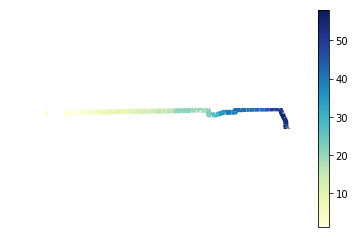

In [24]:
bunching_gdf.plot(column="counts", legend=True, cmap='YlGnBu', linewidth=5).set_axis_off()

The number of bunching incidents increases as the buses travel further east. This result is intuitive: there are more opportunities for the eastbound buses to get off schedule the further they travel along the route. Once a group of buses become bunched, it may be difficult for them to become unbunched, unless one of the drivers take deliberate action to do so, e.g. stopping and waiting for several minutes.

The heatmap gives a general idea of where bunching tends to occur, but it would be helpful if it had some more context. Luckily, the [contextily](https://github.com/darribas/contextily) package makes it easy to add background maps to plots created with geopandas. Read a short tutorial [here](https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html).

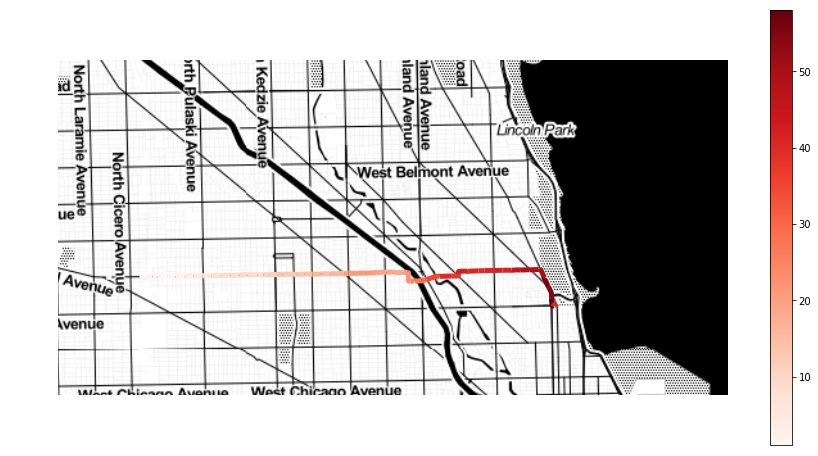

In [32]:
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/toner/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    ax.axis((xmin, xmax, ymin, ymax))
    return basemap

f, ax = plt.subplots(1, figsize=(15, 8))
ax.axis([-9770000, -9750000, 5145000, 5155000])

bunching_gdf.crs = {'init': 'epsg:4326'}
bunching_gdf = bunching_gdf.to_crs(epsg=3857)
bunching_gdf.plot(column="counts", ax=ax, legend=True, cmap='Reds', linewidth=5)

ax.set_axis_off()
add_basemap(ax, zoom=12)
plt.show()

### Create small multiple maps indexed by time of day
To see how bunching varies throughout the day, I count the number of bunching incidents over different time periods and create a map for each. The CTA defines four weekday service intervals that I use:
* AM Peak: 6AM-9AM
* Midday: 9AM-3PM
* PM Peak: 3PM-6PM
* Evening: 7PM-10PM

In [44]:
cta_time_periods = [6, 9, 15, 19, 22]
cta_time_period_labels = ["AM Peak", "Midday", "PM Peak", "Evening"]
travels_waits["bin"] = pd.cut(travels_waits.decimal_time, cta_time_periods, labels=cta_time_period_labels, right=False)

binned_grouped = travels_waits[travels_waits["wait|15417"] < 2].groupby(['origin', 'bin']).count().tatripid.to_frame().reset_index().rename({'tatripid': 'counts'}, axis='columns')
binned_grouped.counts = binned_grouped.counts.fillna(0)
binned_gdf = segmented_stops.merge(binned_grouped, left_on="stpid", right_on="origin")

binned_gdf.crs = {'init': 'epsg:4326'}
binned_gdf = binned_gdf.to_crs(epsg=3857)

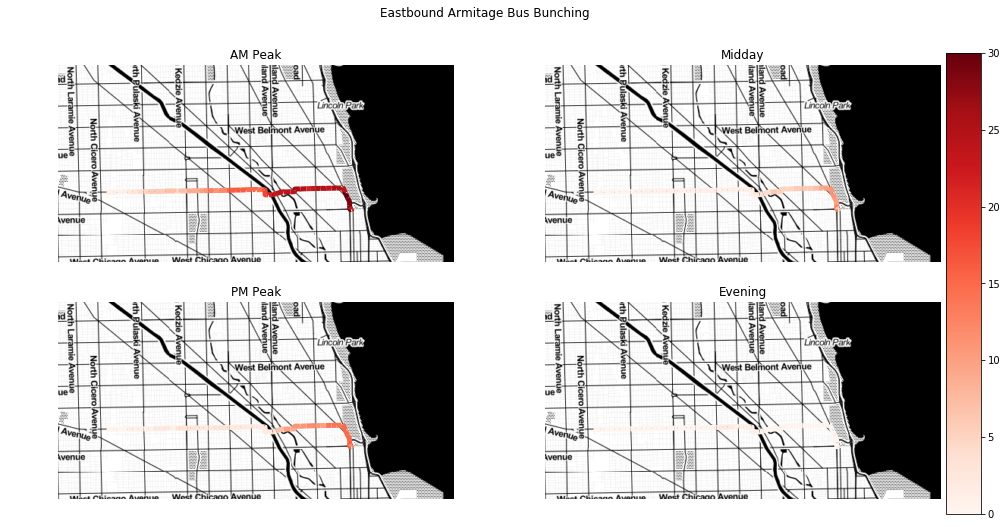

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle("Eastbound Armitage Bus Bunching")

bin_names = [["AM Peak", "Midday"], ["PM Peak", "Evening"]]
vmin = 0
vmax = binned_gdf.counts.max()
for i, r in enumerate(bin_names):
    for j, c in enumerate(r):
        _ax = ax[i][j]
        binned_gdf[binned_gdf.bin == c].plot(column="counts", ax=_ax, cmap='Reds', linewidth=5, vmin=vmin, vmax=vmax)
        _ax.axis([-9770000, -9750000, 5145000, 5155000])
        _ax.title.set_text(c)
        _ax.set_axis_off()
        add_basemap(_ax, zoom=12)

cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)

plt.show()

Most bunching incidents for eastbound trips were observed during morning rush hour. Again, this result is intuitive: during morning rush hour, there is more traffic congestion in eastbound lanes as commuter travel downtown, so it is more likely for the buses to get off schedule.

These observations were made in March 2019.